In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

In [2]:
%load_ext autoreload
%autoreload 2
from fastai import *
from fastai.text import * 
from fastai.callbacks import *
import pandas as pd
from tqdm import tnrange, tqdm_notebook

In [3]:
# See how many devices are around
print('Devices available: ', torch.cuda.device_count())
# Set it to a particular device
CUDA_DEVICE = 6
print('Set device: ', CUDA_DEVICE)
torch.cuda.set_device(CUDA_DEVICE)
# Check which device you are on
print('Current device: ', torch.cuda.current_device())

Devices available:  8
Set device:  6
Current device:  6


In [4]:
DATA_PATH = '../../data/agent-benchmark'
TRAIN_DATASET = os.path.join(DATA_PATH, 'train.csv')
VAL_DATASET = os.path.join(DATA_PATH, 'val.csv')
TEST_DATASET  = os.path.join(DATA_PATH, 'test.csv')

In [5]:
LM_PATH=Path('../../models/ulmfit/lm/agent-benchmark')
LM_PATH.mkdir(exist_ok=True)

In [6]:
def read_data(filename):
    data = pd.read_csv(filename, sep=";", names =['utterance','label'], header=None, dtype={'utterance':str, 'label': str} )
    return data

In [7]:
train_dataset = read_data(TRAIN_DATASET).dropna()
val_dataset = read_data(VAL_DATASET).dropna()
test_dataset = read_data(TEST_DATASET).dropna()

In [55]:
tokenizer = Tokenizer(lang='en', n_cpus=10)

In [56]:
data_lm = TextLMDataBunch.from_df(LM_PATH, train_df = train_dataset, valid_df = val_dataset,  bs=128, text_cols=0)

In [57]:
data_lm.save('data_lm_agent-benchmark')

In [58]:
data_lm = load_data(LM_PATH, 'data_lm_agent-benchmark', bs=64)

In [150]:
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0, callback_fns=ShowGraph)
learn.freeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 3.98E-02


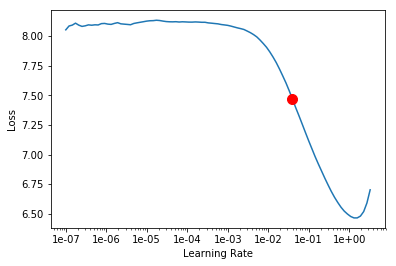

In [60]:
learn.lr_find()
learn.recorder.plot(suggestion=True, skip_start=0)

epoch,train_loss,valid_loss,accuracy,time
0,6.185343,4.096468,0.269364,00:03
1,4.575740,3.530401,0.331027,00:03
2,3.818509,3.369839,0.352232,00:03
3,3.332387,3.312397,0.360435,00:03
4,3.004106,3.303550,0.360491,00:03


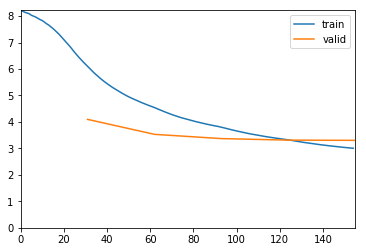

Better model found at epoch 0 with val_loss value: 4.096467971801758.
Better model found at epoch 1 with val_loss value: 3.5304012298583984.
Better model found at epoch 2 with val_loss value: 3.3698391914367676.
Better model found at epoch 3 with val_loss value: 3.3123972415924072.
Better model found at epoch 4 with val_loss value: 3.3035500049591064.


In [61]:
learn.fit_one_cycle(5, 3e-2, moms=(0.8,0.7),callbacks=[ShowGraph(learn), SaveModelCallback(learn, name='wiki-en-FT-dataset-head-best')])

In [ ]:
learn.load('wiki-en-FT-dataset-head-best') 

epoch,train_loss,valid_loss,accuracy,time
0,2.999609,3.787731,0.260212,00:03
1,3.060439,3.245954,0.366462,00:03
2,2.808640,3.193988,0.376451,00:03
3,2.423686,3.234649,0.384208,00:03
4,2.036407,3.305608,0.385491,00:03


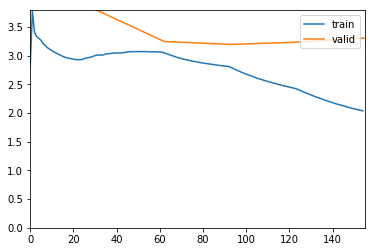

Better model found at epoch 0 with val_loss value: 3.787731409072876.
Better model found at epoch 1 with val_loss value: 3.2459542751312256.
Better model found at epoch 2 with val_loss value: 3.1939876079559326.


In [152]:
learn.unfreeze()
learn.fit_one_cycle(5, 3e-2, moms=(0.8,0.7), callbacks=[ShowGraph(learn), SaveModelCallback(learn, name='wiki-en-FT-dataset-step2-best')])

In [153]:
np.exp(3.193988)

24.385483092069457

In [ ]:
learn.purge()
learn.load('wiki-en-FT-dataset-step2-best')

In [155]:
learn.save_encoder('wikien-FT-dataset-en-encoder')

In [156]:
!cp ../../models/ulmfit/lm/agent-benchmark/models/wikien-FT-dataset-en-encoder.pth models/

In [157]:
learn.predict('increase ', 3)

'increase  the volume xxbos'

In [158]:
data_class = TextClasDataBunch.from_df(path = "", train_df = train_dataset, valid_df = val_dataset, test_df = test_dataset,  vocab=data_lm.train_ds.vocab,tokenizer=tokenizer, bs=128, text_cols=['utterance'], label_cols=['label'])

In [198]:
learn = text_classifier_learner(data_class, AWD_LSTM, drop_mult=0.5, callback_fns=ShowGraph)
learn.load_encoder('wikien-FT-dataset-en-encoder')
learn.freeze()

/opt/conda/envs/fastai/lib/python3.6/site-packages/fastai/datasets.py:164: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  with open(fpath, 'r') as yaml_file: return yaml.load(yaml_file)


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 8.32E-02


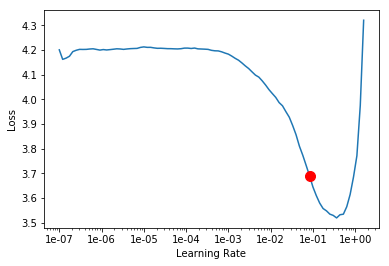

In [199]:
learn.lr_find()
learn.recorder.plot(suggestion=True, skip_start=0)

epoch,train_loss,valid_loss,accuracy,time
0,1.952661,1.448793,0.615046,00:04
1,1.727294,1.422722,0.609184,00:04
2,1.647359,1.302106,0.637030,00:04
3,1.532743,1.263427,0.653151,00:04
4,1.410064,1.128933,0.693210,00:04
5,1.305788,1.075014,0.702980,00:04
6,1.235571,1.069350,0.712750,00:04


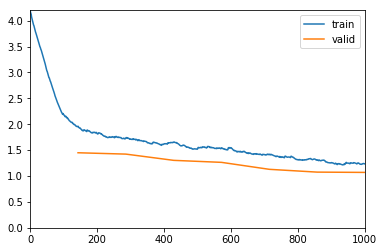

Better model found at epoch 0 with val_loss value: 1.4487931728363037.
Better model found at epoch 1 with val_loss value: 1.4227217435836792.
Better model found at epoch 2 with val_loss value: 1.302106499671936.
Better model found at epoch 3 with val_loss value: 1.2634267807006836.
Better model found at epoch 4 with val_loss value: 1.128933310508728.
Better model found at epoch 5 with val_loss value: 1.0750141143798828.
Better model found at epoch 6 with val_loss value: 1.069350242614746.


In [200]:
learn.fit_one_cycle(7, 6E-02, moms=(0.8,0.7), callbacks=[ShowGraph(learn), SaveModelCallback(learn, name='wiki-en-FT-agent-benchmark-classifier-head-best')])

In [ ]:
learn.load('wiki-en-FT-agent-benchmark-classifier-head-best')

epoch,train_loss,valid_loss,accuracy,time
0,1.219342,1.018276,0.719590,00:04
1,1.073093,0.974925,0.728383,00:04


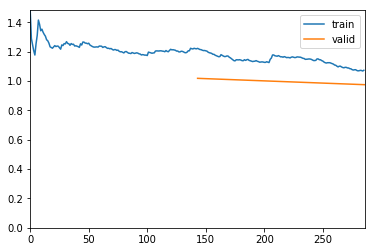

Better model found at epoch 0 with val_loss value: 1.0182760953903198.
Better model found at epoch 1 with val_loss value: 0.9749254584312439.


In [202]:
learn.freeze_to(-2)
learn.fit_one_cycle(2, slice(7E-03/(2.6**4),7E-03), moms=(0.8,0.7), callbacks=[ShowGraph(learn), SaveModelCallback(learn, name='wiki-en-FT-agent-benchmark-classifier-step2-best')])


In [ ]:
learn.load('wiki-en-FT-agent-benchmark-classifier-step2-best')

epoch,train_loss,valid_loss,accuracy,time
0,1.024845,0.973265,0.735222,00:06
1,1.029304,0.928229,0.733757,00:06
2,0.907393,0.907930,0.749878,00:06
3,0.825273,0.899693,0.749878,00:06


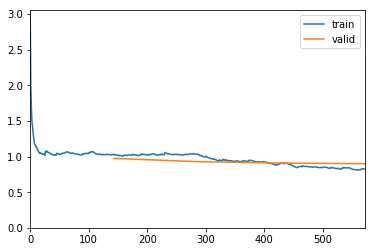

Better model found at epoch 0 with val_loss value: 0.9732652902603149.
Better model found at epoch 1 with val_loss value: 0.9282287359237671.
Better model found at epoch 2 with val_loss value: 0.9079296588897705.
Better model found at epoch 3 with val_loss value: 0.8996928334236145.


In [204]:
learn.freeze_to(-3)
learn.fit_one_cycle(4, slice(7E-03/(2.6**4),7E-03), moms=(0.8,0.7), callbacks=[ShowGraph(learn), SaveModelCallback(learn, name='wiki-en-FT-agent-benchmark-classifier-step3-best')])


In [ ]:
learn.load('wiki-en-FT-agent-benchmark-classifier-step3-best')

epoch,train_loss,valid_loss,accuracy,time
0,0.803971,0.901848,0.746947,00:07
1,0.800126,0.900410,0.748412,00:07
2,0.773678,0.896063,0.750855,00:07
3,0.806699,0.895540,0.750855,00:07
4,0.815186,0.904674,0.751343,00:07


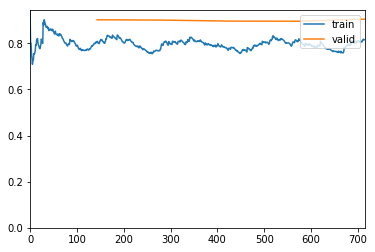

Better model found at epoch 0 with val_loss value: 0.9018479585647583.
Better model found at epoch 1 with val_loss value: 0.9004099369049072.
Better model found at epoch 2 with val_loss value: 0.8960630297660828.
Better model found at epoch 3 with val_loss value: 0.8955395817756653.


In [216]:
learn.unfreeze()
learn.fit_one_cycle(5, slice(1E-04/(2.6**4),1E-04), moms=(0.8,0.7), callbacks=[ShowGraph(learn), SaveModelCallback(learn, name='wiki-en-FT-agent-benchmark-classifier-step4-best')])

In [ ]:
learn.load('wiki-en-FT-agent-benchmark-classifier-step4-best')

In [218]:
y = []
for item in test_dataset.itertuples():
    label = item[2]
    label_id = learn.data.classes.index(label)
    y.append(label_id)

In [219]:
preds_test = learn.get_preds(ds_type = DatasetType.Test, ordered=True)

In [220]:
y_hat = torch.argmax(preds_test[0], dim=1)

In [221]:
from sklearn.metrics import classification_report
print(classification_report(y, y_hat, target_names=learn.data.classes, digits=3))

                           precision    recall  f1-score   support

             IOT_cleaning      0.955     0.875     0.913        48
               IOT_coffee      0.936     0.880     0.907        50
                  IOT_hue      0.907     0.958     0.932       214
                 IOT_wemo      0.854     0.854     0.854        41
             QA_celebrity      0.796     0.759     0.777       108
            QA_definition      0.831     0.871     0.850       124
               QA_factoid      0.746     0.754     0.750       195
                 QA_maths      0.775     0.816     0.795        38
            QA_open_query      0.465     0.392     0.425       120
                 QA_stock      0.902     0.920     0.911        50
              alarm_query      0.659     0.730     0.692        37
             alarm_remove      0.697     0.575     0.630        40
                alarm_set      0.746     0.917     0.822        48
               audio_mute      0.774     0.632     0.696     

In [8]:
classes = {}

for index, row in test_dataset.iterrows():
    try:
        symptom_label = row['label']
        utterance = row['utterance']
        utt_arr = utterance.split()
        utt_count = len(utt_arr)
        if symptom_label not in classes:
            classes[symptom_label] = {'tokens': utt_count, 'utterances': 1, 'avg': utt_count }
        else:
            classes[symptom_label]['tokens'] += utt_count
            classes[symptom_label]['utterances'] += 1
            classes[symptom_label]['avg'] = classes[symptom_label]['tokens']/classes[symptom_label]['utterances']

    except:
        print(json_line)

for c in classes:
    print(c + ';' + str(classes[c]['avg']))

cooking_recipe;6.844444444444444
alarm_set;7.604166666666667
recommendation_movies;7.209302325581396
transport_traffic;6.627906976744186
email_query;6.7175141242937855
calendar_set_event;9.239583333333334
QA_maths;7.0
general_feedback;3.661870503597122
podcasts_play;5.395833333333333
transport_taxi;6.780487804878049
general_confirmation;4.558139534883721
news_set_notification;7.190476190476191
transport_train;8.74736842105263
calendar_delete_event;6.02054794520548
datetime_query;5.2444444444444445
IOT_coffee;5.68
weather_request;6.946428571428571
general_conversation;4.745454545454545
QA_celebrity;5.703703703703703
music_play;5.39344262295082
general_confusion;4.142857142857143
QA_factoid;6.938461538461539
QA_stock;6.9
IOT_hue;5.219626168224299
social_post;7.379310344827586
music_question;5.7727272727272725
lists_remove;5.08641975308642
weather_question;6.3522727272727275
QA_open_query;9.783333333333333
music_settings;4.7
IOT_wemo;5.341463414634147
lists_query;5.463157894736842
email_r